# Multinomial sampling of simulated population

In [2]:
import numpy as np
import pandas as pd

from ThesisScripts.MyModel import Population, Clone
from ThesisScripts.Analyses import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#matplotlib preamble, taken from http://blog.juliusschulz.de/blog/ultimate-ipython-notebook
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 7
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

## Reference simulations

In [3]:
# Test cell: Reference population

# set seed to get same result for each test simulation
np.random.seed(123)

l = 10**8
q = 10**(-3)
testRef = Population(l, q, mutfactor=1, death_frac=0.3)
testRef.simulate()
print("testRefotal population size:", testRef.size)
print("Generations:", testRef.gen)
print()
print("Start clone size:", testRef.start_clone.size)
print("Total number of mutations:", sum(testRef.mut_vec))
print("Number of subclones:", len(testRef.clones[1:]))
print("Total size of subclones:", sum([x.size for x in testRef.clones[1:]]))
print("Dead clones:", len([x for x in testRef.clones if x.size == 0]))
print()

testRefotal population size: 116402657
Generations: 35

Start clone size: 114956110
Total number of mutations: 166236
Number of subclones: 166236
Total size of subclones: 1446547
Dead clones: 14208



In [4]:
test_df = final_data(testRef)
test_df.head()

,Birthday,q,Final size,Family size,Allele frequency,Mutations,Children,Weight,RGB color
Clone ID,,,,,,,,,
A,0,0.001,114956110,116402657,1.000000,0,164368,1,"(0, 0, 0)"
A.0,7,0.001,0,0,0.000000,1,0,1,"(96, 113, 126)"
A.1,15,0.001,156548,157277,0.001351,1,225,1,"(198, 141, 156)"
A.2,15,0.001,65209,65862,0.000566,1,92,1,"(108, 63, 84)"
A.3,16,0.001,0,0,0.000000,1,0,1,"(3, 17, 88)"


## The sampling method

Details: see Methods.tex

In [5]:
def sample(data, size, det_lim):
    '''
    Performs multinomial sampling on a given dataset. Calculates the new sampled clone sizes, corresponding family
    sizes and new Allele Frequencies.
    
    Parameters
    ----------
    * data : pandas.DataFrame, dataset in final_data() format containing simulated tumor clones
    * size : int, total number of cells to be sampled (should be smaller than original population size)
    * det_lim : int, detection limit, minimal family size of clones to be included in sample
        
    Returns
    -------
    * sampled_clones : pandas.DataFrame, new DataFrame containing only sampled clones, same format as final_data()
                        but with additional columns: "sampled_size", "sampled_fam_size" and "sampled_AF"
    
    '''
    N_sample = size  # total size of sampled cells
    
    # filter clones on detection limit
    sampled_clones = data.loc[data["Family size"] >= det_lim]
    N_total = np.sum(sampled_clones["Final size"].values)
    
    size_sum = 0     # sum of sizes of all preceding clones, starting at 0
    sampled_sum = 0  # sum of sampled sizes of all preceding clones, starting at 0
    
    # calculate sampled clone sizes
    sampled_clones = sampled_clones.assign(sampled_size = np.zeros(len(sampled_clones), dtype=int))  # add new empty column
    
    for index, clone in sampled_clones.iterrows():
        n = clone["Final size"]
        x = np.random.binomial(N_sample - sampled_sum, n/(N_total - size_sum))
        sampled_clones.loc[index, "sampled_size"] = int(x)
        
        size_sum += n
        sampled_sum += x
        
    # calculate sampled family sizes
    sampled_clones = sampled_clones.assign(sampled_fam_size = np.zeros(len(sampled_clones), dtype=int))  # add new empty column
    
    for index, clone in sampled_clones.iterrows():
        mask = sampled_clones.index.str.contains(str(index)+'.', regex=False)  # mask to find clone's children
        sampled_fam_size = clone["sampled_size"] + np.sum(sampled_clones.loc[mask, "sampled_size"].values)
        sampled_clones.loc[index, "sampled_fam_size"] = sampled_fam_size
        
    # filter out clones with sampled fam size == 0
    sampled_clones = sampled_clones.loc[sampled_clones["sampled_fam_size"] > 0]
    
    # calculate sampled Allele Frequencies
    sampled_clones = sampled_clones.assign(sampled_AF = lambda clone: clone.sampled_fam_size / N_sample)
    
    
    return sampled_clones

In [6]:
%%time
sampled_test_df = sample(test_df, 10**6, det_lim=100)

CPU times: user 2.54 s, sys: 40.3 ms, total: 2.58 s
Wall time: 2.7 s


In [7]:
print(len(test_df))
print(len(sampled_test_df))
sampled_test_df.head()

166237
1065


,Birthday,q,Final size,Family size,Allele frequency,Mutations,Children,Weight,RGB color,sampled_size,sampled_fam_size,sampled_AF
Clone ID,,,,,,,,,,,,
A,0,0.001,114956110,116402657,1.000000,0,164368,1,"(0, 0, 0)",992364,1000000,1.000000
A.1,15,0.001,156548,157277,0.001351,1,225,1,"(198, 141, 156)",1306,1306,0.001306
A.2,15,0.001,65209,65862,0.000566,1,92,1,"(108, 63, 84)",543,546,0.000546
A.4,17,0.001,7082,7145,0.000061,1,9,1,"(248, 203, 138)",61,61,0.000061
A.6,17,0.001,7895,8012,0.000069,1,12,1,"(186, 187, 151)",64,64,0.000064


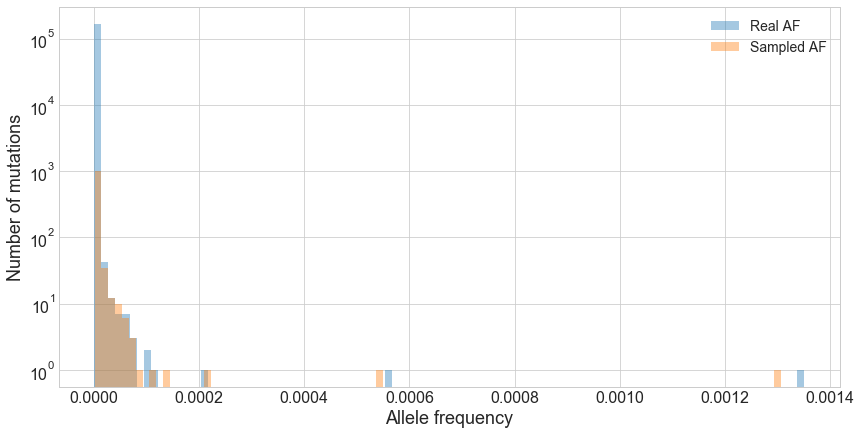

In [8]:
sns.distplot(test_df.iloc[1:]["Allele frequency"], kde=False, bins=100, label="Real AF")
sns.distplot(sampled_test_df.iloc[1:]["sampled_AF"], kde=False, bins=100, label="Sampled AF")
plt.yscale('log')
plt.legend()
plt.xlabel('Allele frequency')
plt.ylabel('Number of mutations')
plt.show()